# Evaluate RegVelo predicted E2f1 downstreamed targets

Notebooks for E2f1 regulatory network analysis

## Library imports

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import torch
from sklearn import metrics

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "pancreatic_endocrine"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "processed" / "cell_cycle_repeat_runs").mkdir(parents=True, exist_ok=True)

In [6]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Function definations

In [7]:
def calculate_aurocs(targets, thresholds):
    """Calculate AUROC."""
    auroc_scores_1 = []
    auroc_scores_2 = []

    for threshold in thresholds:
        # Convert continuous ground truth to binary based on threshold
        chip_targets = np.array(chip_target.index.tolist())[chip_target.iloc[:, 0] > threshold].tolist()
        targets.loc[:, "gt"] = 0
        targets.loc[:, "gt"][targets.index.isin(chip_targets)] = 1

        fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:, "gt"], targets.loc[:, "prior"])
        auroc_1 = metrics.auc(fpr, tpr)
        fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:, "gt"], targets.loc[:, "weight"])
        auroc_2 = metrics.auc(fpr, tpr)

        auroc_scores_1.append(auroc_1)
        auroc_scores_2.append(auroc_2)

    return auroc_scores_1, auroc_scores_2

## Data loading

In [8]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

# Prepare skeleton
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

# Prepare TF
TF = adata.var_names[adata.var["TF"]]

Loading E2f1 ChIP-seq targets as ground truth

In [9]:
chip_target = pd.read_csv(DATA_DIR / DATASET / "raw" / "E2f1_target.csv", index_col=0, sep="\t")

## filter targets only keep significant edges
chip_targets = np.array(chip_target.index.tolist())[chip_target.iloc[:, 0] > 200].tolist()

In [10]:
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


### Repeat run model

Under `soft_mode` due to the number of gene regulation parameter need to be estimated, we can repeat run models for five times, and aggregate inferred GRN to get robust estimation

In [11]:
SELECT_CELLS = (adata.obs["clusters"] == "Ductal") & (adata.obs["phase"] == "S")

In [12]:
## repeat models
for nrun in range(5):
    print("training model...")
    REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = REGVELOVI(adata, W=W.T, regulators=TF)
    vae.train()

    print("save model...")
    model_name = "rgv_model_" + str(nrun)
    model = DATA_DIR / DATASET / "processed" / "cell_cycle_repeat_runs" / model_name
    vae.save(model)

training model...


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


save model...


In [13]:
grns = []
for nrun in range(0, 5):
    model = DATA_DIR / DATASET / "processed" / "cell_cycle_repeat_runs" / f"rgv_model_{nrun}"
    ### load model
    vae = REGVELOVI.load(model, adata)
    # grn1 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
    grns.append(
        vae.module.v_encoder.GRN_Jacobian(torch.tensor(adata.layers["Ms"][SELECT_CELLS, :]).to("cuda:0"))
        .cpu()
        .detach()
        .clone()
    )

GRN = torch.mean(torch.stack(grns), dim=0).clone()

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/cell_cycle_repeat_runs/r
         gv_model_0/model.pt already downloaded                                                                    


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/cell_cycle_repeat_runs/r
         gv_model_1/model.pt already downloaded                                                                    


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/cell_cycle_repeat_runs/r
         gv_model_2/model.pt already downloaded                                                                    


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/cell_cycle_repeat_runs/r
         gv_model_3/model.pt already downloaded                                                                    


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/cell_cycle_repeat_runs/r
         gv_model_4/model.pt already downloaded                                                                    


/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...


## Targets analysis

In [14]:
targets = GRN[:, [i == "E2f1" for i in adata.var.index]].detach().cpu().numpy()

## load prior GRN
prior = vae.module.v_encoder.mask_m_raw[:, [i == "E2f1" for i in adata.var.index]].detach().cpu().numpy()

In [15]:
targets = pd.DataFrame(targets, index=adata.var.index)
targets.loc[:, "weight"] = targets.iloc[:, 0].abs()
targets.loc[:, "prior"] = prior

### Define ground truth

In [16]:
targets.loc[:, "gt"] = 0
targets.loc[:, "gt"][targets.index.isin(chip_targets)] = 1

### Evaluate performance

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:, "gt"], targets.loc[:, "prior"])
metrics.auc(fpr, tpr)

0.552079829577307

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:, "gt"], targets.loc[:, "weight"])
metrics.auc(fpr, tpr)

0.6778786859513398

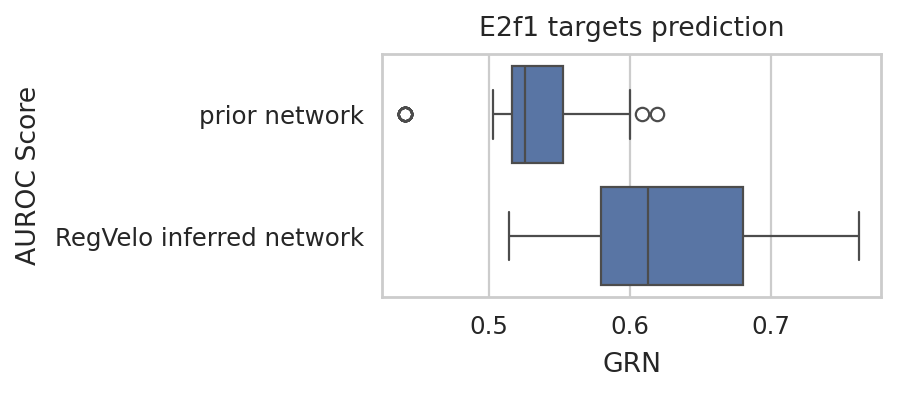

In [19]:
# Define thresholds using quantiles
np.random.seed(0)
num_thresholds = 100
quantile_99 = np.quantile(chip_target.iloc[:, 0], 0.99)
thresholds = np.linspace(0, quantile_99, num_thresholds)

# Calculate AUROC scores for different thresholds
auroc_scores_prior, auroc_scores_regvelo = calculate_aurocs(targets, thresholds)

plt.rcParams["svg.fonttype"] = "none"
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 2))
    data = pd.DataFrame(
        {
            "AUROC": auroc_scores_prior + auroc_scores_regvelo,
            "GRN": ["prior network"] * len(auroc_scores_prior)
            + ["RegVelo inferred network"] * len(auroc_scores_regvelo),
        }
    )

    # Plot the boxplot
    sns.boxplot(y="GRN", x="AUROC", data=data)

    plt.xlabel("GRN")
    plt.ylabel("AUROC Score")
    plt.title("E2f1 targets prediction")

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "GRN_boxplot.svg", format="svg", transparent=True, bbox_inches="tight")

In [20]:
scipy.stats.wilcoxon(auroc_scores_prior, auroc_scores_regvelo)

WilcoxonResult(statistic=273.0, pvalue=9.6068198354694e-15)

## Visualize GRN

In [21]:
GRN_visualize = targets.sort_values("weight", ascending=False).iloc[:20, :]

In [22]:
graph = pd.DataFrame(
    {"from": ["E2f1"] * 20, "to": GRN_visualize.index.tolist(), "status": GRN_visualize.loc[:, "prior"]}
)

color_map = ["skyblue"]
for node in GRN_visualize.index.tolist():
    if graph.loc[graph["to"] == node, "status"].values[0] == 1:
        color_map.append("darkgrey")
    else:
        color_map.append("lightgrey")

In [23]:
G = nx.from_pandas_edgelist(graph, source="from", target="to", create_using=nx.DiGraph())

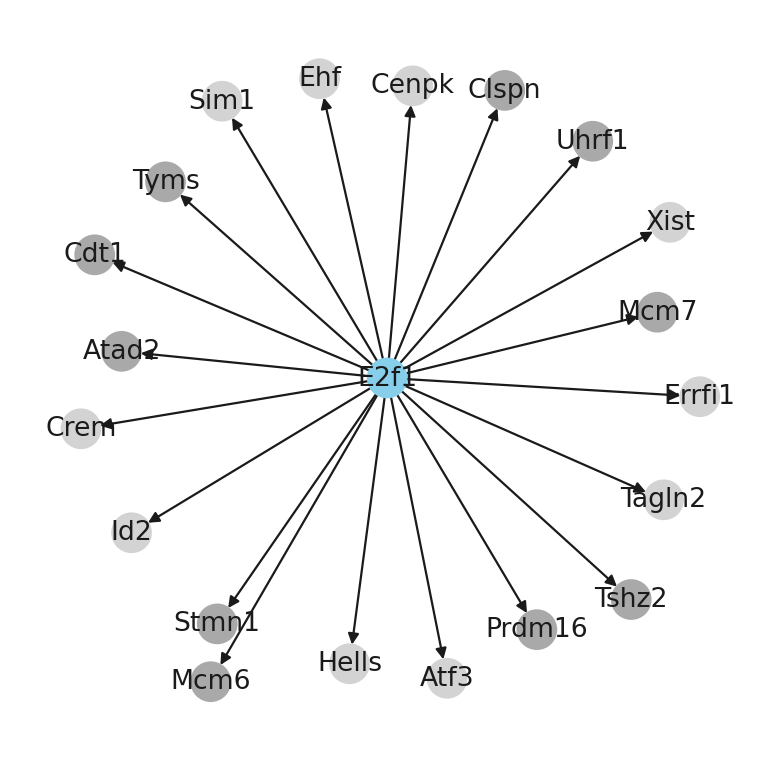

In [24]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, arrowsize=10, node_color=color_map)

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / DATASET / "E2f1_GRN.svg", format="svg", transparent=True, bbox_inches="tight")